In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Import all the necessary files!
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# TRANSFER LEARNING

# Importing Inceptıon Model

In [2]:
path_inception = "../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
# we freeze the inception model by selecting mixed7 conv layer
last_layer = pre_trained_model.get_layer('mixed7') # Modelin Bu layerına kadar ki kısmını al demek.
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


#  Model building


In [4]:
# The callback helps us to choose on which accuracy level we want to stop model   
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True


In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)             
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (6, activation='softmax')(x)          

model = Model( pre_trained_model.input, x)  

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

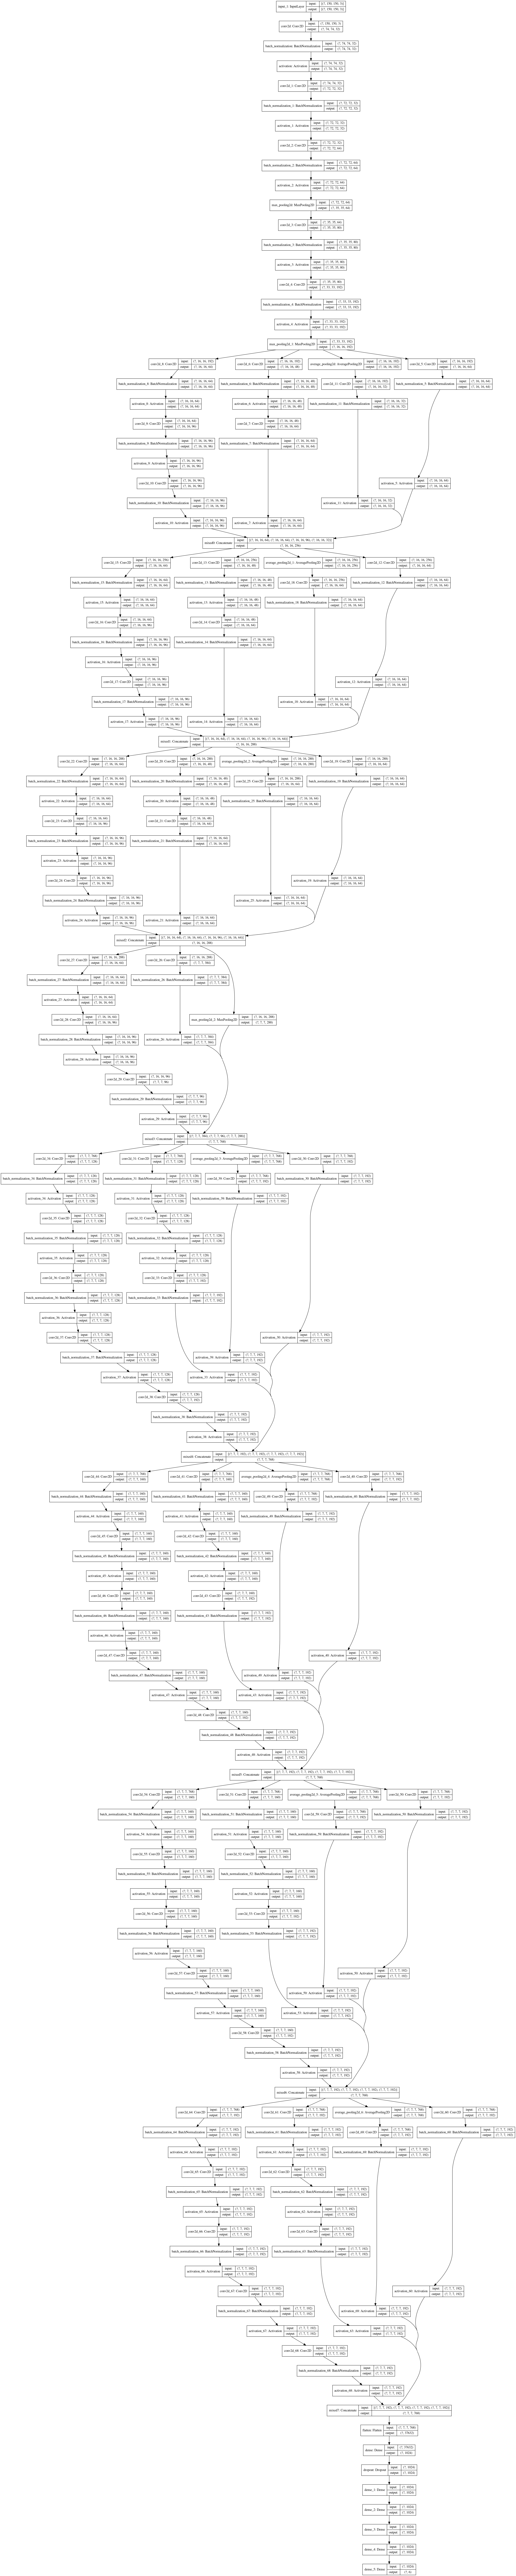

In [6]:
# Dot representation of the model
from IPython.display import SVG
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

In [7]:
# We assign each image directory to different variables

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

# Define our example directories and files
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
validation_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/'



train_buildings_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/buildings')
train_forest_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/forest')
train_glacier_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/glacier')
train_mountain_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain')
train_sea_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/sea')
train_street_dir = os.path.join('/kaggle/input/intel-image-classification/seg_train/seg_train/street')


validation_buildings_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings')
validation_forest_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/forest')
validation_glacier_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/glacier')
validation_mountain_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/mountain')
validation_sea_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/sea')
validation_street_dir = os.path.join('/kaggle/input/intel-image-classification/seg_test/seg_test/street')


pred_images_dir = os.path.join('/kaggle/input/intel-image-classification/seg_pred/seg_pred')
pred_images_fnames = os.listdir(pred_images_dir)

train_buildings_fnames = os.listdir(train_buildings_dir)
train_forest_fnames = os.listdir(train_forest_dir)
train_glacier_fnames = os.listdir(train_glacier_dir)
train_mountain_fnames = os.listdir(train_mountain_dir)
train_sea_fnames = os.listdir(train_sea_dir)
train_street_fnames = os.listdir(train_street_dir)


validation_buildings_fnames = os.listdir(validation_buildings_dir)
validation_forest_fnames = os.listdir(validation_forest_dir)
validation_glacier_fnames = os.listdir(validation_glacier_dir)
validation_mountain_fnames = os.listdir(validation_mountain_dir)
validation_sea_fnames = os.listdir(validation_sea_dir)
validation_street_fnames = os.listdir(validation_street_dir)



print("TRAİNİNG SET")
print("train_buildings_fnames",len(train_buildings_fnames))
print("train_forest_fnames", len(train_forest_fnames))
print("train_glacier_fnames", len(train_glacier_fnames))
print("train_mountain_fnames", len(train_mountain_fnames))
print("train_sea_fnames", len(train_sea_fnames))
print("train_street_fnames", len(train_street_fnames))


print("*" * 20)
print("VALIDATION SET")
print("validation_buildings_fnames",len(validation_buildings_fnames))
print("validation_forest_fnames", len(validation_forest_fnames))
print("validation_glacier_fnames", len(validation_glacier_fnames))
print("validation_mountain_fnames", len(validation_mountain_fnames))
print("validation_sea_fnames", len(validation_sea_fnames))
print("validation_street_fnames", len(validation_street_fnames))


print("*" * 20)
print("pred_images_fnames", len(pred_images_fnames))


TRAİNİNG SET
train_buildings_fnames 2191
train_forest_fnames 2271
train_glacier_fnames 2404
train_mountain_fnames 2512
train_sea_fnames 2274
train_street_fnames 2382
********************
VALIDATION SET
validation_buildings_fnames 437
validation_forest_fnames 474
validation_glacier_fnames 553
validation_mountain_fnames 525
validation_sea_fnames 510
validation_street_fnames 501
********************
pred_images_fnames 7301


## Data augmentation

In [30]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255.)

desired_batch_size = 32

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size =desired_batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))  


# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = desired_batch_size,
                                                          class_mode  = 'categorical',
                                                          shuffle=False,
                                                          target_size = (150, 150))



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [31]:
# It shows  classes in the train set
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [32]:
# It shows  classes in the test set
validation_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [33]:
callbacks = myCallback()

In [34]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy


history = model.fit(train_generator,
                              validation_data = validation_generator,
                              steps_per_epoch = len(train_generator)/desired_batch_size,
                              epochs = 20,
                              validation_steps = len(validation_generator)/desired_batch_size,
                              verbose = 1,
                              callbacks = [callbacks]) 

Epoch 1/10
14/13 [==============================] - 4s 300ms/step - loss: 0.4840 - accuracy: 0.8281 - val_loss: 0.3435 - val_accuracy: 0.8646
Epoch 2/10
14/13 [==============================] - 4s 288ms/step - loss: 0.4343 - accuracy: 0.8259 - val_loss: 0.6806 - val_accuracy: 0.7396
Epoch 3/10
14/13 [==============================] - 4s 302ms/step - loss: 0.4591 - accuracy: 0.8371 - val_loss: 0.6082 - val_accuracy: 0.7917
Epoch 4/10
14/13 [==============================] - 4s 297ms/step - loss: 0.4809 - accuracy: 0.8192 - val_loss: 0.2050 - val_accuracy: 0.9271
Epoch 5/10
14/13 [==============================] - 4s 286ms/step - loss: 0.3959 - accuracy: 0.8527 - val_loss: 0.5389 - val_accuracy: 0.8021
Epoch 6/10
14/13 [==============================] - 4s 275ms/step - loss: 0.4190 - accuracy: 0.8460 - val_loss: 0.2304 - val_accuracy: 0.9167
Epoch 7/10
14/13 [==============================] - 4s 281ms/step - loss: 0.5073 - accuracy: 0.8237 - val_loss: 0.1675 - val_accuracy: 0.9583
Epoch 

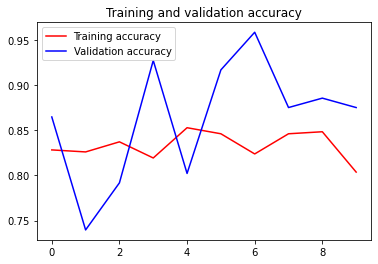

<Figure size 432x288 with 0 Axes>

In [35]:
# Plotting accuracy and loss values of the train and validation sets
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Prediction of Test set

In [36]:
# Predicting the Test images
pred=model.evaluate_generator(validation_generator,verbose=1)

94/94 [==============================] - 8s 80ms/step - loss: 0.3497 - accuracy: 0.8663


In [37]:
test_labels= validation_generator.labels
test_labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [38]:
# Plot confusion matrix 
import matplotlib.pyplot as plt
# Note: This code snippet for confusion-matrix is taken directly from the SKLEARN website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')

0.8663333333333333


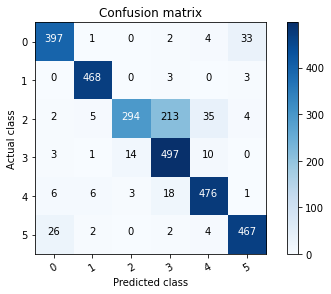

In [39]:
import sklearn.metrics as metrics
from collections import Counter
import itertools

validation_generator.reset()
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=-1)
classes = validation_generator.classes

print(sum(y_pred==classes)/validation_generator.samples)

confusion_matrix = metrics.confusion_matrix(y_true=classes, y_pred=y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes = range(6))

In [29]:
"""
# UPLOAD YOUR OWN PHOTO AND RUN IT IF YOU WISH


import numpy as np

from keras.preprocessing import image


 
# predicting images
path = "../input/photos/a1.png"
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

print(classes)


"""


'\n#\xa0UPLOAD YOUR OWN PHOTO AND RUN IT IF YOU WISH\n\n\nimport numpy as np\n\nfrom keras.preprocessing import image\n\n\n \n# predicting images\npath = "../input/photos/a1.png"\nimg = image.load_img(path, target_size=(150, 150))\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\n\nimages = np.vstack([x])\nclasses = model.predict(images, batch_size=10)\n\nprint(classes)\n\n\n'